# YOLO 11 Model Test on Selected Images

In [ ]:
from pathlib import Path
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

# Set all paths and configuration variables
MODEL_PATH = r"thermal_segmentation/thermalbg_nano/weights/best.pt"
IMAGE_PATH = r"./data/thermal_yolo/val/images/Flug1_105_DJI_0006_R.tiff"
DATASET_YAML_PATH = r"./data/thermal_yolo/dataset.yaml"

### Images with Ground Truth available

Run the following cell:

In [ ]:
def test_model_on_image(model_path, image_path, dataset_yaml_path, conf_threshold=0.25, iou_threshold=0.45):
    """
    Test a YOLO model on an image and display predictions vs ground truth.

    Args:
        model_path: Path to the trained model (e.g. 'best.pt')
        image_path: Path to the test image (TIFF 4 channels)
        dataset_yaml_path: Path to the dataset.yaml file
        conf_threshold: Confidence threshold for predictions (default 0.25)
        iou_threshold: IoU threshold for NMS (default 0.45)
    """
    model_path = Path(model_path)
    image_path = Path(image_path)
    dataset_yaml_path = Path(dataset_yaml_path)

    # Check model existence
    if not model_path.exists():
        print(f"Model not found: {model_path}")
        return

    # Load model
    print(f"Loading model: {model_path.name}")
    model = YOLO(str(model_path))

    # Load dataset configuration
    with open(dataset_yaml_path, 'r') as f:
        dataset_config = yaml.safe_load(f)

    class_names = dataset_config['names']

    # Check image existence
    if not image_path.exists():
        print(f"Image not found: {image_path}")
        val_images_dir = Path(dataset_config['path']) / "val" / "images"
        available_images = list(val_images_dir.glob("*.tiff"))
        if available_images:
            image_path = available_images[0]
            print(f"Using instead: {image_path.name}")
        else:
            print(f"No image available")
            return

    print(f"\n{'='*80}")
    print(f"TEST ON: {image_path.name}")
    print(f"{'='*80}")

    # Load TIFF image
    try:
        import tifffile
        data = tifffile.imread(image_path)
    except ImportError:
        from PIL import Image
        data = np.array(Image.open(image_path))

    if data.shape[0] != 4:
        print(f"Unexpected shape: {data.shape}, expected (4, H, W)")
        return

    height, width = data.shape[1], data.shape[2]
    rgb_img = np.transpose(data[[2, 1, 0], :, :], (1, 2, 0)).astype(np.uint8)
    thermal = data[3]

    # Load Ground Truth
    label_path = image_path.parent.parent / "labels" / image_path.name.replace('.tiff', '.txt')
    gt_labels = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    gt_labels.append({
                        'class_id': int(parts[0]),
                        'coords': [float(x) for x in parts[1:]],
                        'is_segmentation': len(parts) > 5
                    })

    # Run prediction
    print(f"Running prediction (conf={conf_threshold}, iou={iou_threshold})...")
    results = model.predict(source=str(image_path), conf=conf_threshold, 
                          iou=iou_threshold, verbose=False)

    boxes = results[0].boxes
    masks = results[0].masks

    print(f"GT: {len(gt_labels)} annotations | Predictions: {len(boxes)} objects")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Test: {image_path.name}', fontsize=16, fontweight='bold')

    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

    # Helper function to draw annotations
    def draw_annotations(ax, annotations, color_map, width, height, show_conf=False, is_prediction=False):
        for ann in annotations:
            if is_prediction:
                class_id = int(ann.cls[0])
                color = color_map[class_id]
                xyxy = ann.xyxy[0].cpu().numpy()
                conf = float(ann.conf[0])
                label = f"{class_names[class_id]} ({conf:.2f})" if show_conf else None
                # BBox
                rect = patches.Rectangle((xyxy[0], xyxy[1]), xyxy[2]-xyxy[0], xyxy[3]-xyxy[1],
                                        linewidth=1.5, edgecolor=color, facecolor='none',
                                        linestyle='--', alpha=0.6)
                ax.add_patch(rect)
            else:
                class_id = ann['class_id']
                color = color_map[class_id]
                if ann['is_segmentation']:
                    seg_pts = np.array([[ann['coords'][i]*width, ann['coords'][i+1]*height] 
                                       for i in range(0, len(ann['coords']), 2)])
                    polygon = patches.Polygon(seg_pts, linewidth=2.5, edgecolor=color,
                                            facecolor='none', linestyle='-',
                                            label=class_names[class_id] if show_conf else None)
                    ax.add_patch(polygon)
                    # BBox from polygon
                    min_x, max_x = seg_pts[:, 0].min(), seg_pts[:, 0].max()
                    min_y, max_y = seg_pts[:, 1].min(), seg_pts[:, 1].max()
                    rect = patches.Rectangle((min_x, min_y), max_x-min_x, max_y-min_y,
                                            linewidth=1.5, edgecolor=color, facecolor='none',
                                            linestyle='--', alpha=0.6)
                    ax.add_patch(rect)
                else:
                    x_c, y_c, w, h = ann['coords'][:4]
                    x1, y1 = (x_c - w/2)*width, (y_c - h/2)*height
                    rect = patches.Rectangle((x1, y1), w*width, h*height, linewidth=2.5,
                                            edgecolor=color, facecolor='none',
                                            label=class_names[class_id] if show_conf else None)
                    ax.add_patch(rect)

    def draw_prediction_masks(ax, boxes, masks, color_map, show_conf=False):
        if masks is None:
            return
        for box, mask in zip(boxes, masks):
            class_id = int(box.cls[0])
            conf = float(box.conf[0])
            color = color_map[class_id]
            mask_array = mask.xy[0]
            if len(mask_array) > 0:
                polygon = patches.Polygon(mask_array, linewidth=2.5, edgecolor=color,
                                        facecolor='none', linestyle='-',
                                        label=f"{class_names[class_id]} ({conf:.2f})" if show_conf else None)
                ax.add_patch(polygon)

    # Plot grids
    titles = ['Original RGB', f'GT ({len(gt_labels)} obj)', f'Predictions ({len(boxes)} obj)',
              'Original Thermal', 'Thermal + GT', 'Thermal + Pred']

    for i, (ax, title) in enumerate(zip(axes.flatten(), titles)):
        if i in [0, 3]:  # Originals
            ax.imshow(rgb_img if i == 0 else thermal, cmap=None if i == 0 else 'inferno')
        elif i in [1, 2]:  # RGB with annotations
            ax.imshow(rgb_img)
            if i == 1:
                draw_annotations(ax, gt_labels, colors, width, height, show_conf=True)
            else:
                draw_prediction_masks(ax, boxes, masks, colors, show_conf=True)
                draw_annotations(ax, boxes, colors, width, height, is_prediction=True)
        else:  # Thermal with annotations
            ax.imshow(thermal, cmap='inferno')
            if i == 4:
                draw_annotations(ax, gt_labels, colors, width, height)
            else:
                draw_prediction_masks(ax, boxes, masks, colors)
                draw_annotations(ax, boxes, colors, width, height, is_prediction=True)
        ax.set_title(title, fontsize=12, color='green' if 'GT' in title else ('blue' if 'Pred' in title else 'black'))
        ax.axis('off')
        # Legend
        if i in [1, 2]:
            handles, labels = ax.get_legend_handles_labels()
            if labels:
                ax.legend(dict(zip(labels, handles)).values(), 
                         dict(zip(labels, handles)).keys(),
                         loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.show()
    # Print details
    print(f"\n{'='*80}")
    print("PREDICTION DETAILS")
    print(f"{'='*80}")
    for i, box in enumerate(boxes):
        class_id = int(box.cls[0])
        conf = float(box.conf[0])
        xyxy = box.xyxy[0].cpu().numpy()
        print(f"\nObject {i+1}: {class_names[class_id]} (conf={conf:.4f})")
        print(f"   BBox: [{xyxy[0]:.1f}, {xyxy[1]:.1f}, {xyxy[2]:.1f}, {xyxy[3]:.1f}]")
        if masks and i < len(masks):
            print(f"   Segmentation: {len(masks[i].xy[0])} points")
    print(f"\nTest completed!")
    print(f"Green=GT, Blue=Predictions | Solid=Segmentation, Dashed=BBox")

TEST MODELLO - Confronto Predizioni vs Ground Truth
Caricamento modello: best.pt

TEST SU: Flug1_105_DJI_0006_R.tiff
Esecuzione predizione (conf=0.25, iou=0.45)...
GT: 11 annotazioni | Predizioni: 7 oggetti


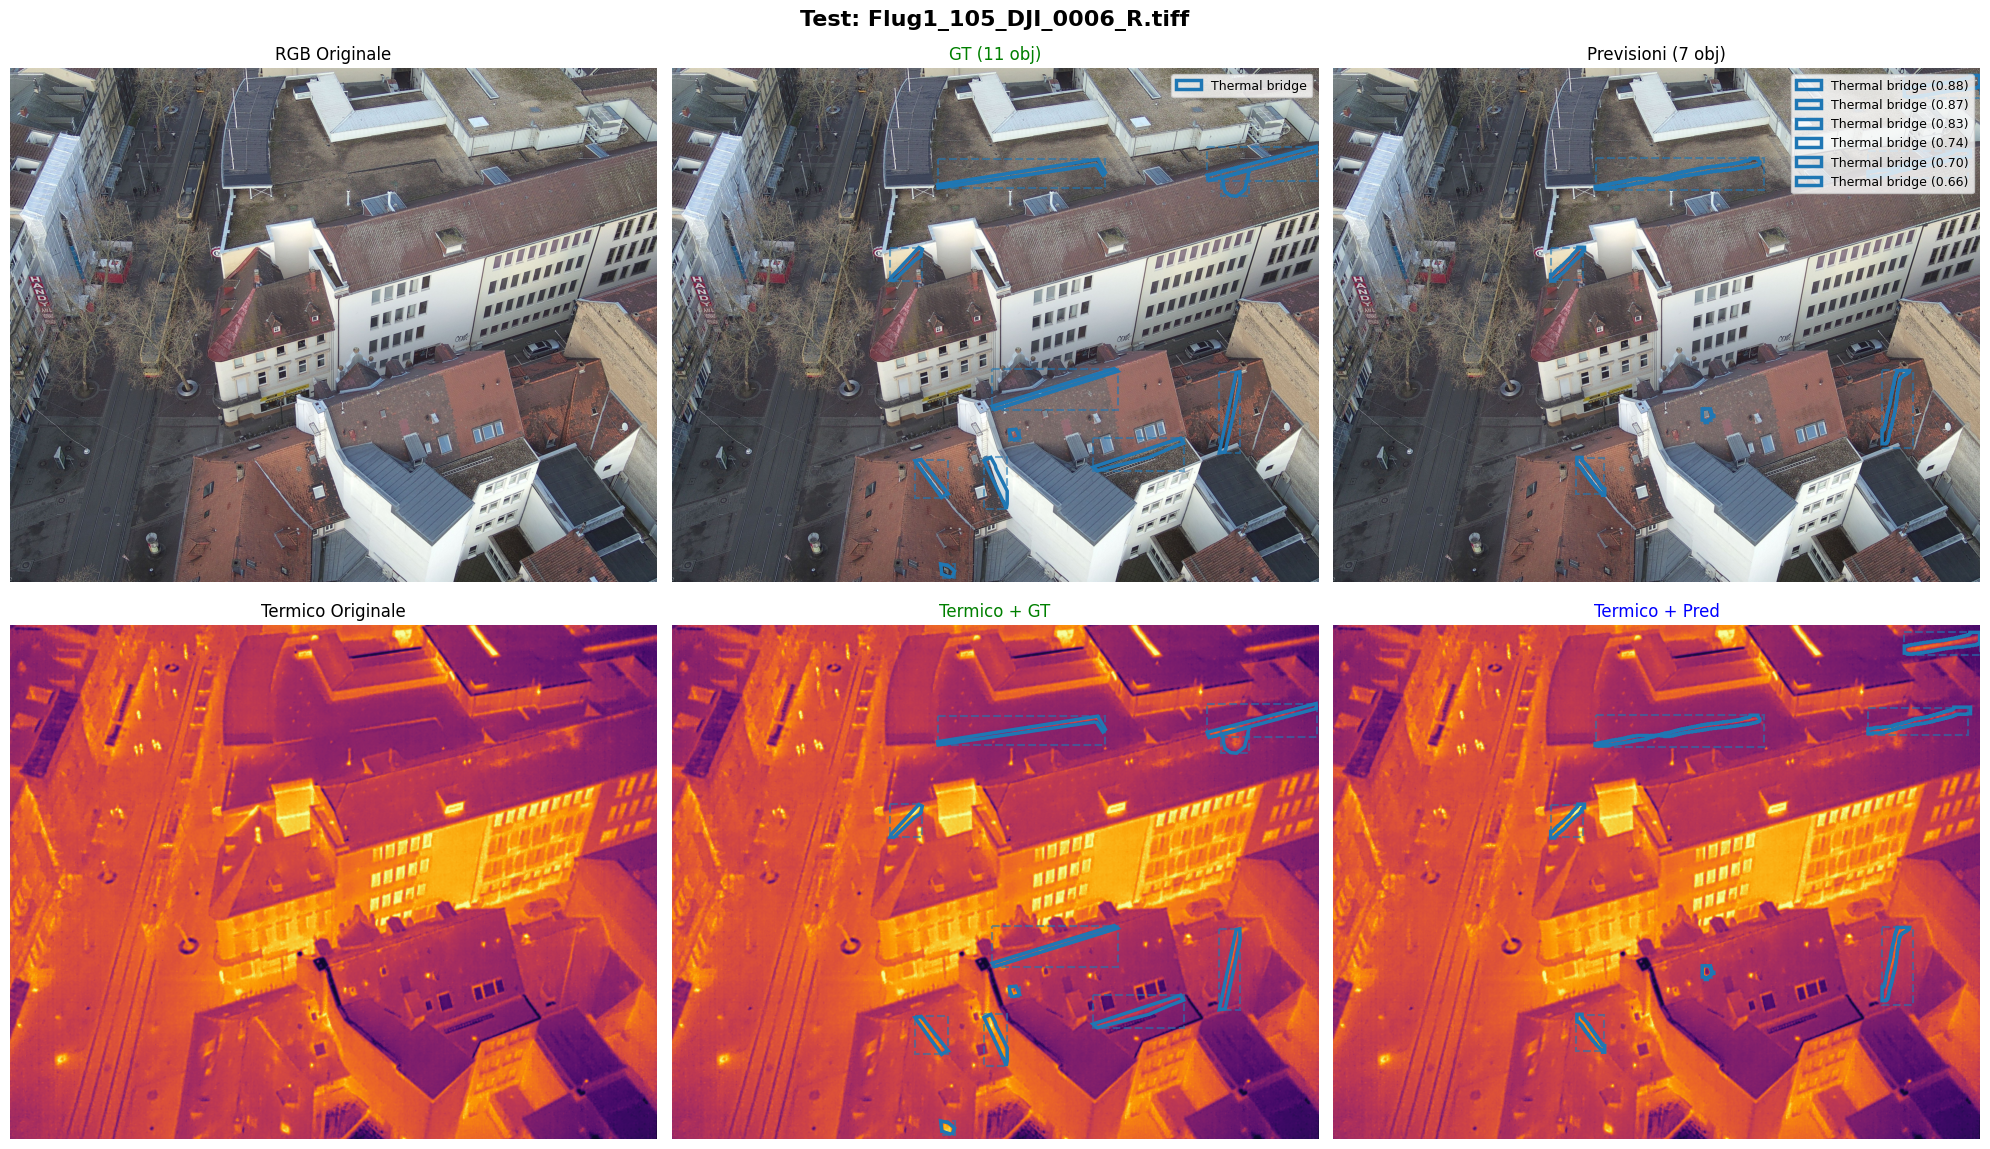


DETTAGLI PREDIZIONI

Oggetto 1: Thermal bridge (conf=0.8812)
   BBox: [1918.2, 1773.6, 1973.0, 1840.4]
   Segmentation: 25 punti

Oggetto 2: Thermal bridge (conf=0.8699)
   BBox: [1266.2, 2034.6, 1410.2, 2221.6]
   Segmentation: 64 punti

Oggetto 3: Thermal bridge (conf=0.8254)
   BBox: [1365.8, 471.9, 2245.9, 638.1]
   Segmentation: 229 punti

Oggetto 4: Thermal bridge (conf=0.7359)
   BBox: [1131.7, 938.5, 1302.0, 1107.2]
   Segmentation: 42 punti

Oggetto 5: Thermal bridge (conf=0.7356)
   BBox: [2975.2, 39.2, 3368.4, 156.1]
   Segmentation: 99 punti

Oggetto 6: Thermal bridge (conf=0.6992)
   BBox: [2858.0, 1573.3, 3018.5, 1979.0]
   Segmentation: 128 punti

Oggetto 7: Thermal bridge (conf=0.6575)
   BBox: [2785.5, 432.7, 3309.5, 573.6]
   Segmentation: 163 punti

Test completato!
Verde=GT, Blu=Predizioni | Linea continua=Segmentation, Tratteggiata=BBox


In [ ]:
print("=" * 80)
print("MODEL TEST - Predictions vs Ground Truth Comparison")
print("=" * 80)

test_model_on_image(
    model_path=MODEL_PATH,
    image_path=IMAGE_PATH,
    dataset_yaml_path=DATASET_YAML_PATH,
    conf_threshold=0.25,
    iou_threshold=0.45
)

### Images without Ground Truth

Run the following cell:

In [ ]:
def predict_on_new_image(model_path, image_path, class_names=['object'], conf_threshold=0.25, iou_threshold=0.45):
    """
    Run inference on a new image (TIFF 4 channels) without Ground Truth.

    Args:
        model_path: Path to the trained model (e.g. 'best.pt')
        image_path: Path to the test image (TIFF 4 channels)
        class_names: List of class names (default ['object'])
        conf_threshold: Confidence threshold for predictions (default 0.25)
        iou_threshold: IoU threshold for NMS (default 0.45)
    """
    model_path = Path(model_path)
    image_path = Path(image_path)

    # Check model existence
    if not model_path.exists():
        print(f"Model not found: {model_path}")
        return

    # Check image existence
    if not image_path.exists():
        print(f"Image not found: {image_path}")
        return

    # Load model
    print(f"Loading model: {model_path.name}")
    model = YOLO(str(model_path))

    print(f"\n{'='*80}")
    print(f"PREDICTION ON: {image_path.name}")
    print(f"{'='*80}")

    # Load TIFF image
    try:
        import tifffile
        data = tifffile.imread(image_path)
    except ImportError:
        print("Error: 'tifffile' library required for 4-channel images.")
        return
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Handle shape (C, H, W) vs (H, W, C)
    if data.ndim == 3 and data.shape[0] == 4:
        height, width = data.shape[1], data.shape[2]
        rgb_img = np.transpose(data[:3, :, :], (1, 2, 0))
        thermal = data[3]
    elif data.ndim == 3 and data.shape[2] == 4:
        height, width = data.shape[0], data.shape[1]
        rgb_img = data[:, :, :3]
        thermal = data[:, :, 3]
    else:
        print(f"Unexpected shape: {data.shape}. Expected 4 channels.")
        return

    # Normalize for visualization if needed
    if rgb_img.dtype != np.uint8:
        import cv2
        rgb_img = cv2.normalize(rgb_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Run prediction
    print(f"Running inference (conf={conf_threshold}, iou={iou_threshold})...")
    results = model.predict(source=str(image_path), conf=conf_threshold, verbose=False)
    boxes = results[0].boxes
    masks = results[0].masks
    print(f"Found: {len(boxes)} objects")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Inference: {image_path.name}', fontsize=16, fontweight='bold')
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names) + 1))

    def draw_predictions(ax, boxes, color_map):
        for box in boxes:
            cls_id = int(box.cls[0])
            idx = cls_id if cls_id < len(class_names) else 0
            label_name = class_names[idx] if cls_id < len(class_names) else f"Class {cls_id}"
            color = color_map[idx]
            xyxy = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            rect = patches.Rectangle((xyxy[0], xyxy[1]), xyxy[2]-xyxy[0], xyxy[3]-xyxy[1],
                                   linewidth=2, edgecolor=color, facecolor='none',
                                   linestyle='-')
            ax.add_patch(rect)

    def draw_masks(ax, masks, boxes, color_map):
        if masks is None:
            return
        for box, mask in zip(boxes, masks):
            cls_id = int(box.cls[0])
            idx = cls_id if cls_id < len(class_names) else 0
            color = color_map[idx]
            if hasattr(mask, 'xy'):
                segments = mask.xy
                for segment in segments:
                    if len(segment) > 0:
                        poly = patches.Polygon(segment, linewidth=1, edgecolor=color,
                                             facecolor=list(color[:3]) + [0.4])
                        ax.add_patch(poly)

    # Original RGB
    axes[0, 0].imshow(rgb_img)
    axes[0, 0].set_title("RGB Input")
    axes[0, 0].axis('off')

    # RGB + Predictions
    axes[0, 1].imshow(rgb_img)
    draw_masks(axes[0, 1], masks, boxes, colors)
    draw_predictions(axes[0, 1], boxes, colors)
    axes[0, 1].set_title(f"RGB + Predictions ({len(boxes)})")
    axes[0, 1].axis('off')

    # Original Thermal
    axes[1, 0].imshow(thermal, cmap='inferno')
    axes[1, 0].set_title("Thermal Input")
    axes[1, 0].axis('off')

    # Thermal + Predictions
    axes[1, 1].imshow(thermal, cmap='inferno')
    draw_masks(axes[1, 1], masks, boxes, colors)
    draw_predictions(axes[1, 1], boxes, colors)
    axes[1, 1].set_title("Thermal + Predictions")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print object details
    print(f"\n{'='*80}")
    print("DETECTED OBJECT DETAILS")
    print(f"{'='*80}")
    for i, box in enumerate(boxes):
        cls_id = int(box.cls[0])
        name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
        conf = float(box.conf[0])
        xyxy = box.xyxy[0].cpu().numpy()
        print(f"Object {i+1}: {name} (conf={conf:.2%})")
        print(f"   Box: x1={xyxy[0]:.0f}, y1={xyxy[1]:.0f}, x2={xyxy[2]:.0f}, y2={xyxy[3]:.0f}")

# Example usage
predict_on_new_image(MODEL, IMAGE, class_names=CLASS_NAMES, conf_threshold=0.10)


In [ ]:
MODEL = 'best.pt'
IMAGE = 'output/DJI_20251124085139_0051_RGBT.tiff'

CLASS_NAMES = ['thermal_bridge'] 

predict_on_new_image(MODEL, IMAGE, class_names=CLASS_NAMES, conf_threshold=0.10)